In [2]:
# --- 0. CONNECT TO THE QUANTUM LOOM ---
import warnings
import os
import logging
import sys

# 1. Kill Standard Warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# 2. Kill ResourceWarnings (Socket warnings from Qiskit Runtime)
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 3. Kill System Logs (TensorFlow/Qiskit/Urllib3)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['QISKIT_SETTINGS'] = '{"suppress_warnings": true}'

logging.getLogger('qiskit').setLevel(logging.CRITICAL)
logging.getLogger('stevedore').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)
logging.getLogger('qiskit_ibm_runtime').setLevel(logging.CRITICAL)

from qiskit_ibm_runtime import QiskitRuntimeService
import os

# Load saved account
try:
    service = QiskitRuntimeService()
    print(f"Connected to IBM Quantum: {service.channel}")
except:
    print("No saved account found.")
    token = input("Please enter your IBM Quantum API Token: ")
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=token)

Connected to IBM Quantum: ibm_quantum_platform


Connecting to IBM Quantum...
Hardware Selected: ibm_torino
Using hardcoded Vacuum Track: [14, 33, 32, 31, 30]
Building the Twin Paradox circuits...
Transpiling with strict physical layout...
Submitting Twin Paradox job to IBM queue...
Job ID: d6g3b5gddp9c73cf2uu0


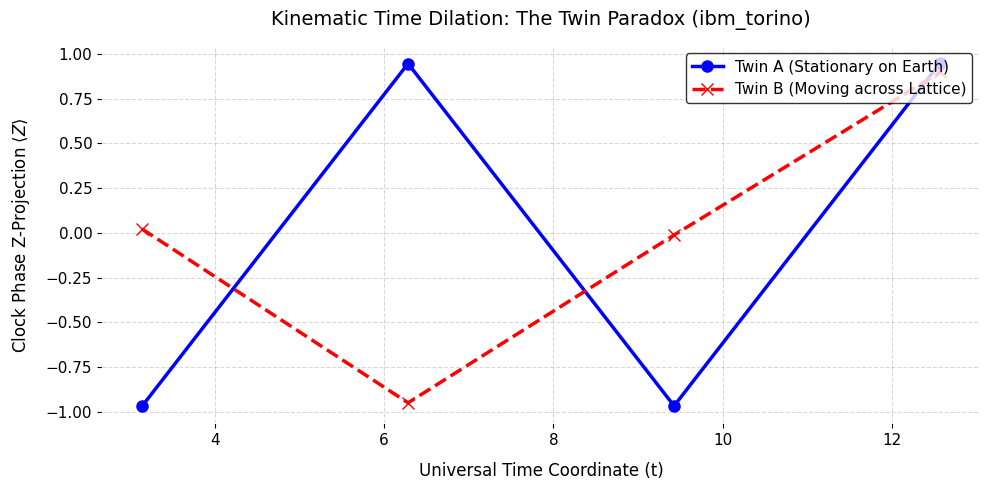

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

# --- 1. CONNECT TO IBM QUANTUM ---
print("Connecting to IBM Quantum...")
service = QiskitRuntimeService()
backend = service.backend('ibm_torino')
print(f"Hardware Selected: {backend.name}")

# --- 2. HARDCODED HARDWARE PATH (IP Protection) ---
# ACADEMIC NOTE: The optimal hardware path was pre-calculated using a proprietary 
# Lattice Weather mapping algorithm (Patent Pending). The specific physical 
# nodes used for the execution in the paper are hardcoded below to isolate 
# the hydrodynamic effects from background topological noise.
#
# IMPORTANT: Replace these with the exact physical qubits from your optimal run!
best_track = [14, 33, 32, 31, 30] 
print(f"Using hardcoded Vacuum Track: {best_track}")

# --- 3. DYNAMIC SPACETIME PARAMETERS ---
time_steps = 4 # We will do 4 discrete movement steps across the track
dt = np.pi     # Time duration of each step
omega = 1.0    # Base ticking rate
gamma_v = 0.5  # Kinematic Drag (Phase consumed by translation through the superfluid)

circuits = []
print("Building the Twin Paradox circuits...")



# We generate a circuit for each point in the journey
for step in range(1, time_steps + 1):
    qr = QuantumRegister(5, 'q')
    cr = ClassicalRegister(2, 'meas')
    qc = QuantumCircuit(qr, cr)
    
    # 1. Initialize Both Twins in superposition (Clocks start at 12:00)
    qc.h(0) # Twin A (Earth) at q0 (which maps to best_track[0])
    qc.h(1) # Twin B (Spaceship) starts at q1 (which maps to best_track[1])
    
    current_pos = 1
    
    # 2. Evolve time and move Twin B
    for t in range(step):
        # Earth ticks normally
        qc.rz(omega * dt, 0)
        
        # Spaceship ticks, but suffers Kinematic Drag due to translation velocity
        qc.rz((omega - gamma_v) * dt, current_pos)
        
        # Spaceship moves physically across the lattice (SWAP to next node)
        if current_pos < 4:
            qc.swap(current_pos, current_pos + 1)
            current_pos += 1
            
    # 3. Measure Earth (q0) and the Spaceship at its current location
    qc.h(0)
    qc.h(current_pos)
    qc.measure(0, 0)
    qc.measure(current_pos, 1)
    
    circuits.append(qc)

# --- 4. EXECUTE ON HARDWARE ---
print("Transpiling with strict physical layout...")
# The initial_layout parameter forces our logical q0-q4 to snap to the hardcoded best_track
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3, initial_layout=best_track)
isa_circuits = pm.run(circuits)

print("Submitting Twin Paradox job to IBM queue...")
sampler = SamplerV2(mode=backend)
job = sampler.run(isa_circuits)
print(f"Job ID: {job.job_id()}")

result = job.result()

# --- 5. PROCESS DATA ---
twin_a_ticks = []
twin_b_ticks = []
x_axis = [dt * i for i in range(1, time_steps + 1)]

for i in range(time_steps):
    counts = result[i].data.meas.get_counts()
    total = sum(counts.values())
    
    p_A_0 = sum(c/total for b, c in counts.items() if b[-1] == '0')
    p_B_0 = sum(c/total for b, c in counts.items() if b[-2] == '0')
    
    twin_a_ticks.append(2 * p_A_0 - 1)
    twin_b_ticks.append(2 * p_B_0 - 1)

# --- 6. PLOT THE RESULTS (Light Theme) ---
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Changed colors to deep blue and red for high contrast on white
ax.plot(x_axis, twin_a_ticks, label='Twin A (Stationary on Earth)', color='blue', linewidth=2.5, marker='o', markersize=8)
ax.plot(x_axis, twin_b_ticks, label='Twin B (Moving across Lattice)', color='red', linewidth=2.5, linestyle='dashed', marker='x', markersize=8)

ax.set_title(f"Kinematic Time Dilation: The Twin Paradox ({backend.name})", fontsize=14, color='black', pad=15)
ax.set_xlabel("Universal Time Coordinate (t)", fontsize=12, color='black', labelpad=10)
ax.set_ylabel(r"Clock Phase Z-Projection $\langle Z \rangle$", fontsize=12, color='black', labelpad=10)

ax.tick_params(colors='black', labelsize=11)
ax.legend(loc="upper right", facecolor='white', edgecolor='black', labelcolor='black', fontsize=11)
ax.grid(True, alpha=0.3, color='gray', linestyle='--')

plt.tight_layout()
plt.show()